# **Noises**

In this notebook, we will study 2 different types of noises in the context of images: [white noise](https://en.wikipedia.org/wiki/White_noise) and [colored noise/correlated](https://en.wikipedia.org/wiki/Colors_of_noise). This will be separate from the [type of noise that appears in images](https://en.wikipedia.org/wiki/Image_noise), this is simply to learn about different noise types from a 2D perspective and understand some basic signal processing concepts. Conventional wisdom would say to start with 1D and then go to 2 dimensions, however I am a visual learner and viewing things as images tends to make more sense to me. This doesn't mean we will skip 1D entirely, we will still visualize our analysis with 1D vectors taken from our 2D arrays. This tutorial assumes vague familiartiy with Computer Vision and the concept of frequency in images. If not please see [source1](https://photo.stackexchange.com/questions/40401/what-does-frequency-mean-in-an-image), [source2](https://theailearner.com/2019/05/05/understanding-frequency-in-images/), [source3](https://thepythoncodingbook.com/2021/08/30/2d-fourier-transform-in-python-and-fourier-synthesis-of-images/)

## Objective
The main goal is learn about different characteristics on white noise and colored/uncorrelated noise. This is a hands on tutorial, while jargon is necessary to help explain things it will be kept to a minimum and links will be provided for more reference. We will provide some basic definitions, but don't worry if you don't understand right away, *most of the concepts are best acquired through [experiential learning](https://www.kent.edu/community/what-experiential-learning-and-why-it-important) i.e. learning by doing.* This tutorial is meant to provide a first look into learning these concepts through example and visually show what each of these things means.

### Definitions
- **Noise** - An unwanted signal that corrupts the original signal
- **Covariance Matrix** - A square matrix that exhibits variances along the diagonal and covariances in the off-diagonal
- **Correlation** - A measure of the similarity between 2 signals
- **Autocorrelation** - A measure of the similarity of a signal with itself
- **Power Spectral Density** - Describes the amount of power in the signal at each frequency
- **Random Variable** - A variable that takes on values randomly where the values are assoviated with a probability (usually defined by a probability distribution)
- **Random (Stochastic) Process** - A series of Random Variables that is usually indexed by time <br>
    - Noise is usally modeled as a Random Process
- ***iid*** - Independent and Identically Distributed --> refers to a collection of random variables where each one has the same probability distribution and all are mutually independent.
    - (see [*iid* VS white noise](https://dsp.stackexchange.com/questions/23881/what-is-the-difference-between-i-i-d-noise-and-white-noise))
- **white noise** - A random noise signal that is uncorrelated and equally spread in power for all frequencies.
- **Colored/Uncorrelated Noise** - A random noise signal that is correlated and does not have an equal spread in power for all frequencies

<br>

Once again, don't worry if you don't understand right away. I recommend to follow through the tutorial to get some intuition and then research these topics on your own.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

Generate Random Gaussian Noise

In [2]:
white_noise = np.random.normal(loc=0, scale=1, size=(256, 256))

Now we will use the white noise to generate colored/correlated noise. We will need to somehow add the spatial correlations, but how? We can use [convolution](https://web.pdx.edu/~jduh/courses/Archive/geog481w07/Students/Ludwig_ImageConvolution.pdf) to perform an [averaging](https://docs.opencv.org/4.x/d4/d13/tutorial_py_filtering.html) operation on the white noise


When we smooth the noise, we are reducing the high frequency components and adding spatial dependencies for each pixel.

In [3]:
kernel = np.ones((5,5))/25
color_noise = cv2.filter2D(white_noise, ddepth=-1, kernel=kernel)

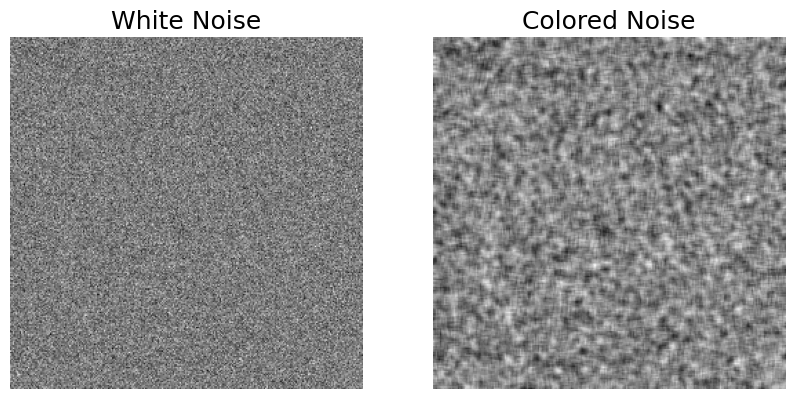

In [4]:
_, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(white_noise, cmap="gray")
ax[0].set_title('White Noise', size=18)
ax[0].axis("off")

ax[1].imshow(color_noise, cmap="gray")
ax[1].set_title('Colored Noise', size=18)
ax[1].axis("off");

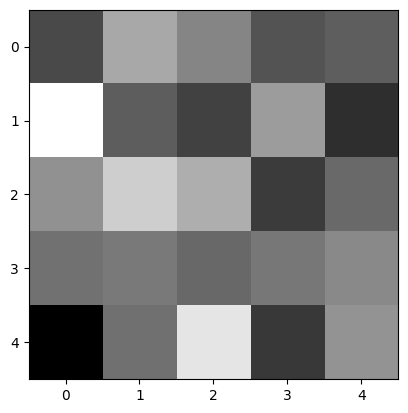

In [133]:
plt.imshow(white_noise[130:135, 130:135], cmap='gray')
# plt.grid(linestyle='-', linewidth=5, color='black')

So far, there is not much to see. The white noise appears a bit grainy and the colored noise seems blurry. Let's dive in further and explore these 2 noises by [estimating their Covariance matrices](https://en.wikipedia.org/wiki/Estimation_of_covariance_matrices) with the sample covariance. 

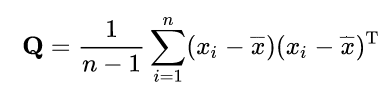


Where the $\bar{x}$ is defined as: 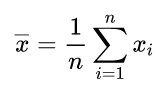


How can we implement this in Python? Think about each row or column as a different random vector generated by a random process. If we simulate this random process N number of times, then we will have N random vectors, and we assume them to be column vectors. The estimation of the Covariance matrix can broken down as:
- Initialize the Covariance matrix to be a matrix of zeros the same size as the original matrix
- For each vector, take it's average and subtact it from all elements. 
    - Multiply this vector by itself (multiply it by it's transpose), this is an outer product and will give us a matrix, 
    - Add all these matrices together for each row or column. 
- Finally normalize to ensure that our estimator is [unbiased](https://en.wikipedia.org/wiki/Bias_of_an_estimator)

We make a simple implementation below that will work for square matrices.

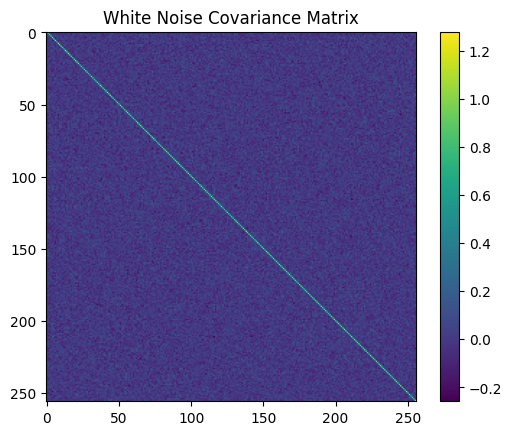

In [59]:
Q = np.zeros_like(white_noise)
for i in range(256): # <-- change the number of vector used
    x = white_noise[:, i]
    Q += np.c_[x - x.mean()] @ np.c_[x - x.mean()].T

Q *= (1/(len(white_noise) - 1))

plt.imshow(Q)
plt.title("White Noise Covariance Matrix")
plt.colorbar();

The cell below shows how this operation can be vectorized, where we . We can also use numpy. Each of these 3 methods should produce similar results aside from some roundoff error.

In [98]:
compute_covariance = lambda X: 1/(len(X) - 1)*((X - X.mean(axis=0)) @ (X.T - X.mean(axis=1)))
# white_cov = np.cov(white_noise) # we can also use numpy

white_cov = compute_covariance(white_noise)
color_cov = compute_covariance(color_noise)

Since these are large matrices they are best displayed as images

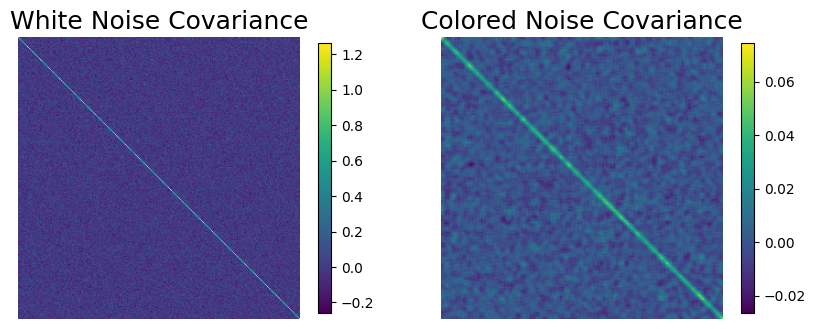

In [99]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
im0 = ax[0].imshow(white_cov)
ax[0].set_title('White Noise Covariance', size=18)
ax[0].axis("off")
plt.colorbar(im0, ax=ax[0], shrink=0.35)

im1 = ax[1].imshow(color_cov)
ax[1].set_title('Colored Noise Covariance', size=18)
ax[1].axis("off")
plt.colorbar(im1, ax=ax[1], shrink=0.35);

Now we're getting somewhere! We can see that the White Noise Covariance has large values along the diagonal with the remaining values being very low indicating that there little to no correlations between respective pixel locations. The Colored Noise Covariance has a fat diagonal indicating that nearby pixels are highly correlated, we can also see the high levels of the terms that are way off diagonal, indicating that some of the pixels far away are in fact correlated. Also compare th values in the color bars, the white noise goes up to 1.2 while the colored noise only goes to 0.08 indicating that there are strong autocorrelations in the white noise and weaker autocorrelations in the colored noise (the correlations are spread out more to neighboring pixels)


Now that we've done this in 2D, let's visualize this in 1D as well

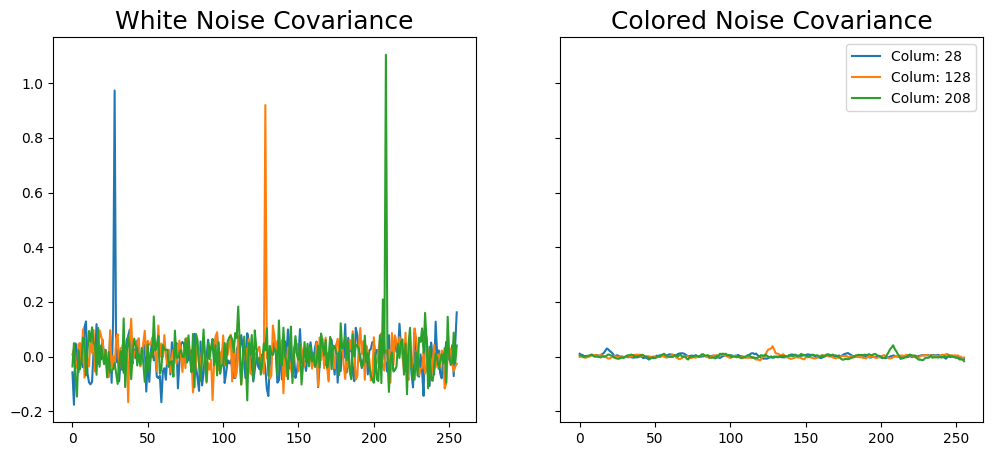

In [70]:
_, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
ax[0].plot(white_cov[:, 28], label="Colum: 28")
ax[0].plot(white_cov[:, 128], label="Colum: 128")
ax[0].plot(white_cov[:, 208], label="Colum: 208")
ax[0].set_title('White Noise Covariance', size=18)

ax[1].plot(color_cov[:, 18], label="Colum: 28")
ax[1].plot(color_cov[:, 128], label="Colum: 128")
ax[1].plot(color_cov[:, 208], label="Colum: 208")
ax[1].set_title('Colored Noise Covariance', size=18)
ax[1].legend();

In the left plot notice the large peaks, these peaks correspond to different positions along the diagonal. These peaks are barely noticable in the right plot. The 1D view is a good way to visualize the magnitude of this difference. Now let's take a look at the [autocorrelations](https://en.wikipedia.org/wiki/Autocorrelation) of this noise.

We have estimated the covariance matrices on the noise arrays, but now let's take a detour and try it out on an image. We should still see a large and fat values along the diagonal, indicating that nearby pixels are correlated with eachother. We will also use our onw version of the estimation and compare it to the one in numpy. In the future, I recommend to always use library implementations, but it is improtant to manually code them yourself at least once.

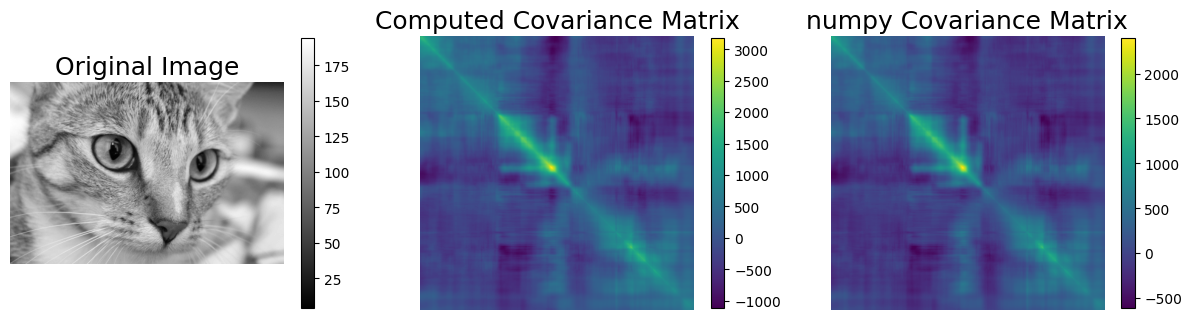

In [108]:
from skimage.data import chelsea

image = cv2.cvtColor(chelsea(), cv2.COLOR_RGB2GRAY)


fig, ax = plt.subplots(1, 3, figsize=(15, 10))
im0 = ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original Image', size=18)
ax[0].axis("off")
plt.colorbar(im0, ax=ax[0], shrink=0.35)

im1 = ax[1].imshow(compute_covariance(image))
ax[1].set_title('Computed Covariance Matrix', size=18)
ax[1].axis("off")
plt.colorbar(im1, ax=ax[1], shrink=0.35);


im2 = ax[2].imshow(np.cov(image))
ax[2].set_title('numpy Covariance Matrix', size=18)
ax[2].axis("off")
plt.colorbar(im2, ax=ax[2], shrink=0.35);

Alright, now let's get back to the main topic: noise. Now let's investigate the autocorrelations of the noise. To compute the spatial autocorrelations we will simply correlate the noise with it with itself. We do this by taking a copy of the noise and sliding it's center pixel along each pixel of the original, this copy of the noise will be equal to the kernel. We set the value of each pixel to the weighted average of the area covered by the kernel, this is the correlation operation which is often erranously referred to as the convolution operation. Where the only different between the correlation and convolution, is the kernel is flipped. The reason for this misnomer possibly stems from the fact that convolutions in Computer Vision usually involve symmetrical kernels. The image below illustrates this operation except for the auto correlation, the kernel is equal to the orginal image, so we have a much larger zero-padding.

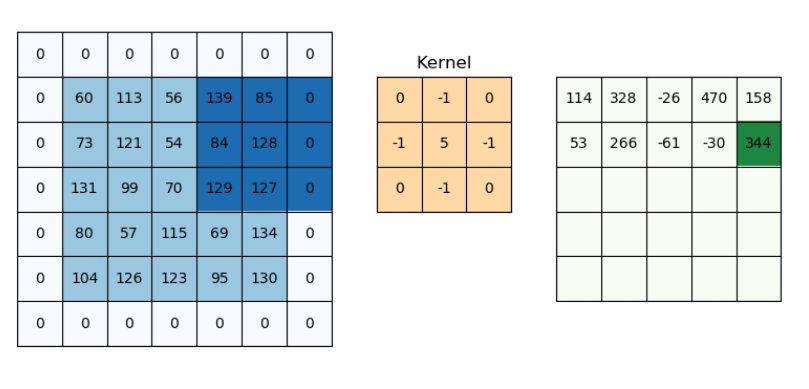

source: https://medium.com/@draj0718/zero-padding-in-convolutional-neural-networks-bf1410438e99


In opencv we can do this efficiently by using the filter2D function.

In [134]:
white_ac = cv2.filter2D(white_noise, ddepth=-1, kernel=white_noise)
color_ac = cv2.filter2D(color_noise, ddepth=-1, kernel=color_noise)

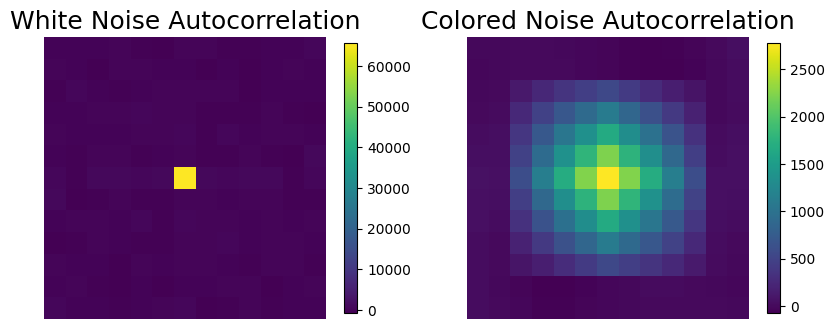

In [135]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
im0 = ax[0].imshow(white_ac[122:135, 122:135])
ax[0].set_title('White Noise Autocorrelation', size=18)
ax[0].axis("off")
plt.colorbar(im0, ax=ax[0], shrink=0.35)

im1 = ax[1].imshow(color_ac[122:135, 122:135])
ax[1].set_title('Colored Noise Autocorrelation', size=18)
ax[1].axis("off")
plt.colorbar(im1, ax=ax[1], shrink=0.35);

Notice how the white noise is just a single pixel*. Think about the copy being slide over the original image, at some point the copy will be directly overlaid on the original image (i.e. at the center pixel). At the center pixel, we expect a large weighted average since we are basically squaring everything. However at every other pixel we receive relatively small values. This means that each pixel is independent and their values do not depend on other pixel values. However each pixel is highly correlated with itself. 


In the right plot we see that several pixels have value, while the center pixel has the largest value, the pixels around also have a decent value. This illustrates the extent or magntiude of the correlation of a single pixel to the pixels that surround it. We also notice that the value of the center pixels is not the same, the one for the white noise has an order of around 60000 and the colored noise has a value of around 2500. This is due to the fact that the correlations are more spread out in the colored noise. 


Think of each pixel as a person, with a finite amount of time. In the white noise, the pixels only spend time with themselves, but in the colored/correlated noise, the pixels, spend time with their neighboring pixels.


<br>

*If you display the computed autocorrelation of the white noise, you will notice that there are a lot of non-negative numbers. In theory, these numbers should be 0, but since we estimated the autocorrelation from a sample (the noise image) we have imperfect numbers. Also, the largest pixel values is on the order of 60000, this is likely to be much larger than the other miscellaneous pixels contained in the white noise auto correlation.

<br> 

Now let's view this in 1D. We could plot each or or column individually, but taking the average across either rows of columns will give us a good representation of the autocorrelations. We choose to take the average of the columns here, and also include the average autocorrelation across all pixels.

Text(0.5, 1.0, 'Colored Noise Autocorrelation')

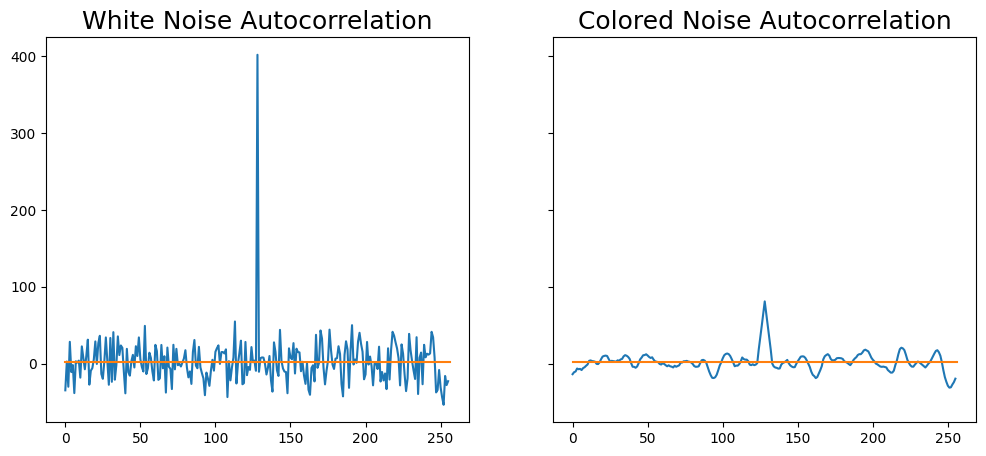

In [148]:
_, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
ax[0].plot(white_ac.mean(axis=0))
ax[0].plot([0, 256], [white_ac.mean(), white_ac.mean()])
# ax[0].plot([0, 256], [np.median(white_ac), np.median(white_ac)])
# ax[0].plot(white_ac[:, 128], label="Colum: 128")
ax[0].set_title('White Noise Autocorrelation', size=18)

ax[1].plot(color_ac.mean(axis=0))
ax[1].plot([0, 256], [color_ac.mean(), color_ac.mean()])
# ax[1].plot([0, 256], [np.median(color_ac), np.median(color_ac)])
# ax[1].plot(color_ac[:, 128], label="Colum: 128")
ax[1].set_title('Colored Noise Autocorrelation', size=18)
# ax[1].legend();

The narrow peak on the left indicates a strong autocorrelation, and fat peak on the right indicates that adjacent value (pixels) are also correlated. Also notice that the white noise has roughly an equal number of autocorrelations above and below the average line. Aside from the large peak, these autocorrelations will cancel eachother out. The colored noise is similar in regards to the average. Also notice that the averages are roughly thhe same, this plays back into how the autocorrelations are similar to the spread of energy.

<br>

Now let's view the Power Spectral Densities (PSDs). According to the [Wiener-Khinchin Theorem](https://en.wikipedia.org/wiki/Wiener%E2%80%93Khinchin_theorem), The PSD is just the Fourier Transform of the autocorrelation function. The PSD describes the distribution of power across the frequencies. 

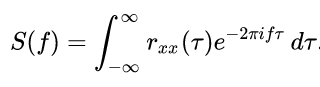



Since we are dealing with images, we have a limited amount of frequencies to work with. The [Nyquist theorem](https://www.imatest.com/docs/nyquist-aliasing/) applied to images states that we can have 0.5 cycles/pixel. So for a (256, 128) image, we would have (128, 64) frequencies in the vertical and horixonal directions.

In [149]:
white_psd = np.abs(np.fft.fftshift(np.fft.fft2(white_ac)))
color_psd = np.abs(np.fft.fftshift(np.fft.fft2(color_ac)))

Let's Display these below, we will manually edit the ticks to indicate the image frequencies.

C:\Users\itber\AppData\Local\Temp\ipykernel_20920\633165977.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels([0, -125, -75, -25, 25, 75, 125]);
C:\Users\itber\AppData\Local\Temp\ipykernel_20920\633165977.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels([0, 125, 75, 25, -25, -75, -125]);
C:\Users\itber\AppData\Local\Temp\ipykernel_20920\633165977.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels([0, -125, -75, -25, 25, 75, 125]);
C:\Users\itber\AppData\Local\Temp\ipykernel_20920\633165977.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels([0, 125, 75, 25, -25, -75, -125]);


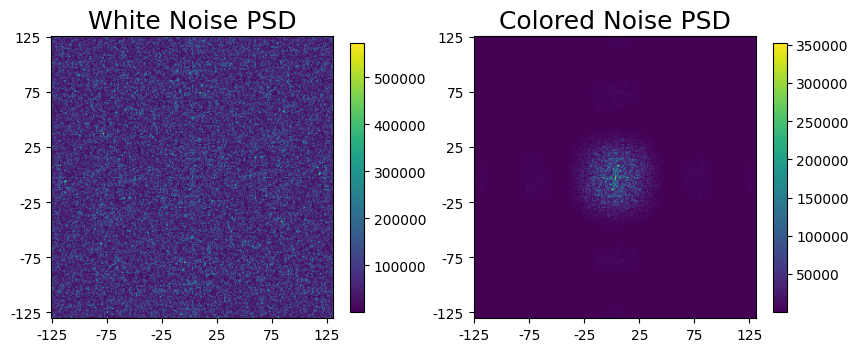

In [170]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
im0 = ax[0].imshow(white_psd)
ax[0].set_title('White Noise PSD', size=18)
ax[0].set_xticklabels([0, -125, -75, -25, 25, 75, 125]);
ax[0].set_yticklabels([0, 125, 75, 25, -25, -75, -125]);
plt.colorbar(im0, ax=ax[0], shrink=0.35)

im1 = ax[1].imshow(color_psd)
ax[1].set_title('Colored Noise PSD', size=18)
ax[1].set_xticklabels([0, -125, -75, -25, 25, 75, 125]);
ax[1].set_yticklabels([0, 125, 75, 25, -25, -75, -125]);
plt.colorbar(im1, ax=ax[1], shrink=0.35);

On the left, the white noise appears relatively constant, meaning that it's power is constant across all frequencies. On the right, the power spectrum is strong at the center and appears to "rolloff" which is characteristic of many forms of colored noise. Now let's visualize this in 1D, where we will take the mean across the columns. (we could also take the mean across the columns and get nearly ther same results, since the PSDs are symmetric in this case)

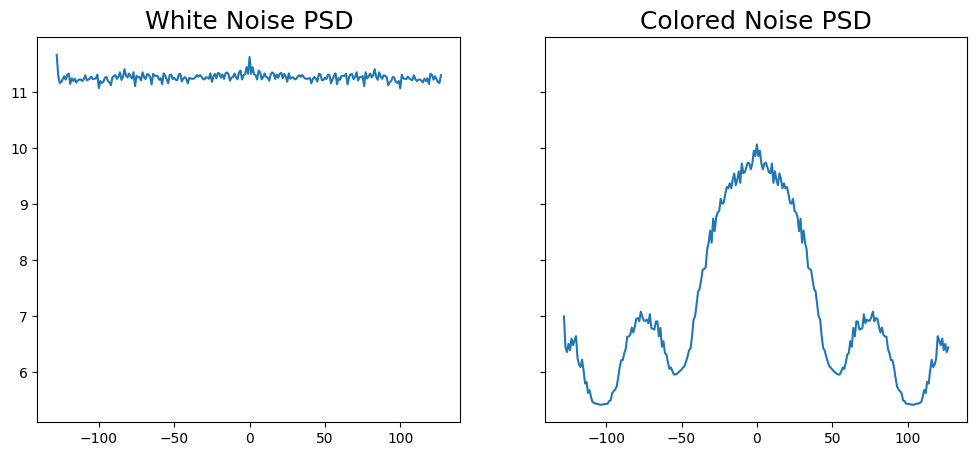

In [151]:
_, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
ax[0].plot(np.arange(-128, 128), np.log(white_psd.mean(axis=0)))
ax[0].set_title('White Noise PSD', size=18)


ax[1].plot(np.arange(-128, 128), np.log(color_psd.mean(axis=0)))
ax[1].set_title('Colored Noise PSD', size=18);

On the left, we can now see the flat power spectrum across all frequencies that is characteristic of white noise. On the right, we can see the variation in power levels across all frequencies that is characteristic of colored noise. Also notice, how we actually plotted the frequencies here. The 0 frequency is the DC compoenent and as we go out to each side, the frequencies get higher and higher. In our (256,256) image we have (128, 128) frequencies in the vertical and horizontal directions. The [Nyquist theorem](https://www.imatest.com/docs/nyquist-aliasing/) applied to images states that we can have 0.5 cycles/pixel. That is we need at least 2 pixels to form a frequency.

Notice that the constant PSD level of the white noise is much higher than that of the colored noise. Based on what we saw with the autocorrelation, we might expect the average levels of each to be the same, but this isn't the case with the PSD. With the PSD we are transforming the autocorrelation into the frequency domain. Now let's think intuitively about this.

The white noise is just a single spike at the center pixel. Think about this spike, at one pixel we are at 0, then at the next, we are at 60000, this is a very large change. Since the frequency has units of $\frac{1}{\text{seconds}}$ we can think of it as a rate of change. Since we are changing the value so drastically over a short distance, this is characteristic of a very high frequency. But why isn't just one high frequency? Why are all the frequencies set to high values? Let's think backwards for a second, a single high frequency in Fourier space corresonds to a sinusoid in image space. 

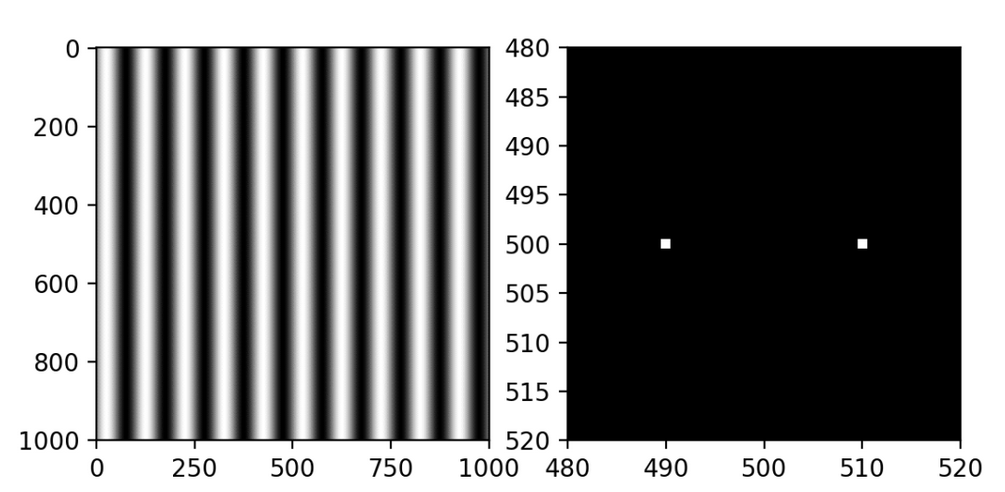
Source: https://thepythoncodingbook.com/2021/08/30/2d-fourier-transform-in-python-and-fourier-synthesis-of-images/

So if we were to sum infinitely many sinusoids in all spatial directions, we would get the a plane of constant frequency values. This spike, is actually the summation of many sinusoids, which is why we need many frequecnies to represent it in frequency space. We will explore this further below.


In fact, we will need the sum of many frequencies up to a high frequency to represent this, which is exactly what the large constant PSD represents. In terms of power, it takes a lot of it to get this high rate of change, so our PSD describes the amount of power necessary for this change. Also to get this high rate of change, all frequencies must be active, this accounts for any rate of change. 

On the right, the overall PSD for the colored noise is much lower, and the corresponding autocorrelation does not have such a large rate of change. It just has a relativvely small hill, so it's PSD is representative of the power needs to get over this small hill.



Let's take another intuitive look at our results. Now let's consider the [Dirac Delta](https://en.wikipedia.org/wiki/Dirac_delta_function) (or impulse function). The Fourier Transform of a Dirac Delta is just a constant value across all frequecnies (theoretically it includes all frequencies up to infinity). The white noise autocorrelation spike is close to a 2D Dirac Delta distribution so we might expect it's Fourier Transform to be a constant level across all horizontal and vertical frequecnies. Now let's connect this to what we discussed above, the Dirac Delta function is an infinite approximation of complex exponentials, but what is a complex exponential? It's just a sinuoid! So the Dirac delta function is a summation of an infinite collection of sinusoids. This confirms our statement above that the Fourier Transfrom of an infinite collection of sinuoids corresponds to a constant power level across all frequencies.

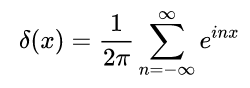
Source: https://en.wikipedia.org/wiki/Dirac_delta_function


The autocorrelation function of the colored noise is similar to a pyramid (or 2D triangle!). The Fourier Transform of a triangle is a squared sinc function, which is what we see in our plots. 

The image below shows some basic Fourier Transfrom pairs, we can compare these to our 1D results and verify that they make sense.

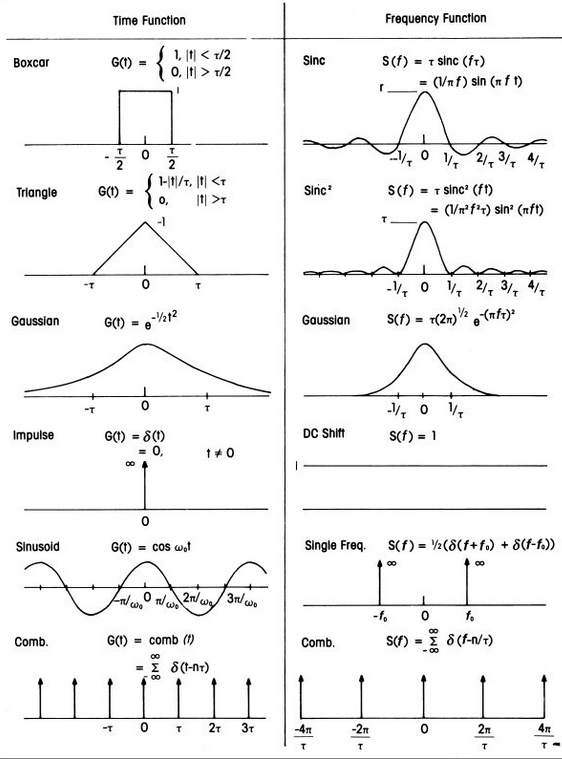


